In [1]:
import requests

import pandas as pd
import numpy as np

import time
import datetime

import urllib

import re

import warnings

from os.path import join

import nltk
from wordcloud import WordCloud

import matplotlib.pyplot as plt

warnings.filterwarnings('ignore')

path='C:/Users/blake.gonthier/Desktop/DataQuest/APIs/'

* Reading in API key to access the New York Times API

In [2]:
with open(join(path,'nyt.txt')) as f:
    file=f.read()
    f.close()
    
li=file.split('\n')
params={}
for i in range(0,len(li),3):
    counter=i
    try:
        params[li[counter]]=li[counter+1]
    except IndexError:
        pass

* Function that allows you to make API Calls to the NYT API
    - Was used since requests.get function did not grant successful authentication

In [3]:
key={'api-key':params['API Key']}

* Error code of 401 shows that permission was denied.

In [4]:
response=requests.get('https://api.nytimes.com/svc/mostpopular/v2/emailed/7.json?',headers=key)
response.status_code

401

* The function below allows the user to make calls to the below APIs that NYT has:
        1. Article Search API
        2. Books API
        3. Most Popular API
        
* The input is the API to call, the following API key that was associated with my account, and a query_dic that supplies optional arguments to the query.


* Once run depending on the API called, specific input is required based on each API's structure in order to make the correct API call.

In [5]:
def call_nyt_api(api,api_key,query_dic):
    
    
    query_dic['api-key']=api_key
    
    base_string='https://api.nytimes.com/svc/'
    
    api_strings={'Article Search Api': 'search/v2/articlesearch.json?','Books Api':'books/v3/',
                'Most Popular Api':'mostpopular/v2/'}
    
    if api=='Most Popular Api':
        
        while True:
            type_pop=input('Which most popular api do you want to view?\nBy emailed, By shared, or By viewed?\n')
            print()
            li=['emailed','shared','viewed']
            
            if type_pop in li:
                break
        
        json_files={'last day':'1.json?','last 7 days':'7.json?','last 30 days':'30.json?','facebook':'facebook.json?'}
        while True:
            total_pop=input('Do you want to see the results from the:\nlast day, last 7 days, last 30 days, or from Facebook?\n')
            print()
            li=['last day','last 7 days','last 30 days','Facebook']
            
            
            if total_pop in li:
                break
        if total_pop!='Facebook':    
            add=type_pop+'/'+json_files[total_pop]
            api_call=api_strings[api]+add
        else:
            
            while True:
                days_ago=input('From how many days ago would you like to view the most '+type_pop+' articles on Facebook?\n')
                print()
                try:
                    days_ago=int(days_ago)
                    break
                except Exception as e:
                    print(e)
                    
            
            add=type_pop+'/'+str(days_ago)+'/'+json_files['facebook']
            api_call=api_strings[api]+add
            
        api_call+=urllib.parse.urlencode(query_dic)
        api_call=base_string+api_call
            
    elif api=='Books Api':
        
        while True:
            type_api=input('Select which part of the Books Api you would like to access:\nLists or Reviews\n')
            print()
            if type_api in ['Lists','Reviews']:
                break
                
        if type_api=='Lists':
            print(str(set(list_names)))
            while True:
                book_li=input('Please Select a book type from above:\n')
                print()
                if book_li in list_names:
                    break
            book_li=book_li.lower().replace(' ','-')
            api_call=base_string+api_strings['Books Api']+'lists/current/'+book_li+'.json?'


            api_call+=urllib.parse.urlencode(query_dic)

        else:
           
            api_call=base_string+api_strings[api]+'reviews.json?'
            urlencode=urllib.parse.urlencode(query_dic)
            urlencode=urlencode.replace('+','%20')
            api_call+=urlencode
            
    elif api=='Article Search Api':
        
        api_call=base_string+api_strings[api]
        urlencode=urllib.parse.urlencode(query_dic)
        api_call+=urlencode
        
            
    
    response=requests.get(api_call)
    # Ensuring the API Key isn't printed out
    api_hashed=re.sub('api-key=.*','api-key=mykey',api_call)
    print('API Call URL:')
    print(api_hashed)
    print()
    print('Response Status Code:')
    print(response.status_code)
    return response
        

* The example below calls the Most Popular API from the NYT, supplies the API Key asscociated with my account, and has no query dictionary input.


* The below output shows the corresponding input for this specific API, along with the final API call link and the response status code.


* The status code is 200 meaning that the API request was fulfilled.

In [6]:
response=call_nyt_api('Most Popular Api',params['API Key'],{})

Which most popular api do you want to view?
By emailed, By shared, or By viewed?
emailed

Do you want to see the results from the:
last day, last 7 days, last 30 days, or from Facebook?
last day

API Call URL:
https://api.nytimes.com/svc/mostpopular/v2/emailed/1.json?api-key=mykey

Response Status Code:
200


* Making a dataframe of results:

In [7]:
df=pd.DataFrame(response.json()['results'])

In [8]:
df.shape

(20, 24)

In [9]:
df.columns

Index(['abstract', 'adx_keywords', 'asset_id', 'byline', 'column',
       'count_type', 'des_facet', 'email_count', 'eta_id', 'geo_facet', 'id',
       'media', 'nytdsection', 'org_facet', 'per_facet', 'published_date',
       'section', 'source', 'subsection', 'title', 'type', 'updated', 'uri',
       'url'],
      dtype='object')

* Making a word cloud for the abstract of all of the popular emailed articles:

In [10]:
combined=''

for a in df['abstract'].map(lambda x:nltk.word_tokenize(x)).values:
    new=''
    for b in a:
        new+=b+' '
    combined+=new

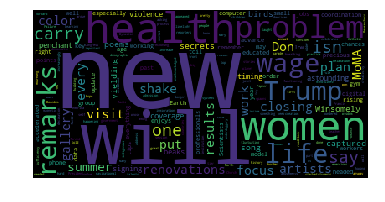

In [11]:
wordcloud=WordCloud().generate(combined)
plt.imshow(wordcloud)
plt.axis('off')
plt.show()

* Filtering out the rows of the dataframe that contain the most popular words:
    1. Will
    2. New
    3. Life
    4. Group

In [12]:
def detect_words(string,words):
    
    parse=string.split(' ')
    
    for a in parse:
        if a in words:
            return True
    
    return False

In [13]:
filt=df[df['abstract'].map(lambda x:detect_words(x,['will','new','women','life','group']))]

* Printing out the results:

In [14]:
for a in filt.abstract:
    print(a)
    print()

Don’t plan to visit MoMA this summer. It’s closing for renovations that will put a new focus on work by women and artists of color. The results will shake up every gallery.

Winsomely captured in poems and song, the birds are yielding new secrets about their astounding beaks and penchant for violence.

New year, new you, right? You may be headed to the gym, but what about the health of your phone, computer and all your precious data? Here are some tips to get your digital life in order.

A small group of well-educated professionals enjoys rising wages, while most workers toil in low-wage jobs with few chances to advance.

As mental health problems among children increase, the government will try having students practice mindfulness, relaxation and breathing exercises.

Mary Pipher’s “Women Rowing North” celebrates the unacknowledged talents and wisdom of older women — a demographic increasingly in the limelight.

Boredom teaches us that life isn’t a parade of amusements. More important

# Making Other API Calls:

## Making the Article Search API call with a query_dic input:


* The corresponding call was successful given the Response Status code of 200.

In [15]:
response2=call_nyt_api('Article Search Api',params['API Key'],{'page':0,'section_name':'Autos'})

API Call URL:
https://api.nytimes.com/svc/search/v2/articlesearch.json?page=0&section_name=Autos&api-key=mykey

Response Status Code:
200


* Below the response2 variable is converted to a dataframe and has the below shape:

In [16]:
df2=pd.DataFrame(response2.json()['response']['docs'])
df2.shape

(10, 16)

* Checking if the received data is correct:

In [17]:
df2.snippet.iloc[9]

'FAA to study residents complaints of flight patterns'

##  Making the Books API call with a query_dic input:

* The corresponding call was successful given the Response Status code of 200.

In [18]:
response3=call_nyt_api('Books Api',params['API Key'],{'author':'Stephen King'})

Select which part of the Books Api you would like to access:
Lists or Reviews
Reviews

API Call URL:
https://api.nytimes.com/svc/books/v3/reviews.json?author=Stephen%20King&api-key=mykey

Response Status Code:
200


* Below the response3 variable is converted to a dataframe and has the below shape:

In [19]:
df3=pd.DataFrame(response3.json()['results'])
df3.shape

(64, 9)

* Listing all of the Stephen King Books:

In [20]:
df3['book_title'].unique()

array(['11/22/63', 'Wolves of the Calla', 'Nightmares and Dreamscapes',
       'Black House', 'The Stand', 'Four Past Midnight', 'Needful Things',
       "Gerald's Game", "Everything's Eventual : 14 Dark Tales", 'It',
       'Full Dark, No Stars', 'Bag of Bones', 'Rose Madder',
       'Doctor Sleep', 'Joyland', 'Under the Dome', 'Revival',
       "Lisey's Story", 'Just After Sunset', 'Duma Key', 'Mr. Mercedes',
       "Stephen King's Danse Macabre", 'Cujo', 'Different Seasons',
       'Christine', 'Pet Sematary', 'Skeleton Crew',
       'The Eyes of the Dragon', 'Misery', 'The Tommyknockers',
       'The Dark Half', 'The Waste Lands: The Dark Tower Book III',
       'Needful Things: The Last Castle Rock Story',
       'Insomnia,Stephen King Library Ed.',
       'The Girl Who Loved Tom Gordon : A Novel',
       'On Writing:  a Memoir of the Craft', 'Dreamcatcher',
       'From a Buick 8', 'The Dark Tower VI', 'Cell', 'Finders Keepers',
       'End of Watch', 'The Outsider', 'Elevation']